<a href="https://colab.research.google.com/github/boyoforex/academic-kickstart/blob/master/Sign-Language-Digits-deep-learning-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1qp-qHcFR5L59byWxz_B-BvQ-_kcDdMHj')

# Course Project - Deep Learning with PyTorch: Zero to GANs

# Introduction
In this course project, I intend to practicalize what I learnt in this course. I would attempt to classify hand-signs using ResNets. The dataset for this project is the Sign-Language-Digits-Dataset which can be access here: https://github.com/ardamavi/Sign-Language-Digits-Dataset 

Details of datasets:

    Image size: 100 x 100 pixels
    Color space: RGB
    Number of classes: 10 (Digits: 0-9)
    Number of participant students: 218
    Number of samples per student: 10


In [ ]:
!pip install jovian --upgrade --quiet

# Importing needed libraries

In [ ]:
import os
import torch
import jovian
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import tarfile
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
project_name = "zero2gans-course-project"

# Importing dataset

In [ ]:
! git clone "https://github.com/ardamavi/Sign-Language-Digits-Dataset.git"

fatal: destination path 'Sign-Language-Digits-Dataset' already exists and is not an empty directory.


In [ ]:
base_dir = './Sign-Language-Digits-Dataset'
print(os.listdir(base_dir))
print(os.listdir(base_dir + "/Dataset"))

['.git', 'Dataset', 'README.md', 'Examples', 'LICENSE']
['3', '7', '4', '5', '2', '8', '0', '9', '1', '6']


In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize([64,64]),
        #transforms.RandomCrop(64, padding=50, padding_mode='reflect'),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True),
])

valid_tfms = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor(), transforms.Normalize(*stats)])
data = ImageFolder(base_dir+'/Dataset', transform=train_tfms)

#data = ImageFolder(base_dir+'/Dataset', transform=torchvision.transforms.Compose(
#        [torchvision.transforms.Resize(64), torchvision.transforms.ToTensor()]))
val_sz = int(0.1*len(data))
train_sz = len(data) - val_sz
train_dt, val_dt = random_split(data, [train_sz, val_sz])
len(train_dt), len(val_dt)

(1856, 206)

In [ ]:
test_sz = 50
train_sz = len(train_dt) - test_sz
train_dt, test_dt = random_split(train_dt, [train_sz, test_sz])
len(train_dt), len(test_dt)

(1806, 50)

# Checking the Image shape and Image Tensor

In [ ]:
image, label = data[2]
print(image.shape, label)
image

torch.Size([3, 64, 64]) 0


tensor([[[0.9827, 1.0408, 1.0602,  ..., 1.0796, 1.0796, 1.0408],
         [0.9827, 1.0214, 1.0408,  ..., 1.0990, 1.0990, 1.0408],
         [1.0021, 1.0408, 1.0602,  ..., 1.0990, 1.0990, 1.0602],
         ...,
         [0.5950, 0.6338, 0.6531,  ..., 0.6531, 0.6531, 0.6144],
         [0.5756, 0.6144, 0.6338,  ..., 0.5756, 0.5756, 0.5368],
         [0.5756, 0.5950, 0.6144,  ..., 0.4787, 0.4787, 0.4399]],

        [[1.0038, 1.0628, 1.0824,  ..., 1.1218, 1.1218, 1.0824],
         [1.0038, 1.0431, 1.0628,  ..., 1.1414, 1.1414, 1.0824],
         [1.0234, 1.0628, 1.0824,  ..., 1.1414, 1.1218, 1.0824],
         ...,
         [0.6104, 0.6498, 0.6694,  ..., 0.6498, 0.6301, 0.5908],
         [0.5711, 0.6104, 0.6301,  ..., 0.5514, 0.5318, 0.4924],
         [0.5514, 0.5711, 0.5908,  ..., 0.4138, 0.4138, 0.3744]],

        [[1.1929, 1.2514, 1.2709,  ..., 1.2514, 1.2514, 1.2124],
         [1.1929, 1.2319, 1.2514,  ..., 1.2709, 1.2709, 1.2124],
         [1.2124, 1.2514, 1.2709,  ..., 1.2905, 1.2905, 1.

In [ ]:
print(data.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


# Example images in the training dataset


In [ ]:
def show_example(image, label):
    print('Label: ', data.classes[label], "("+str(label)+")")
    plt.imshow(image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  2 (2)


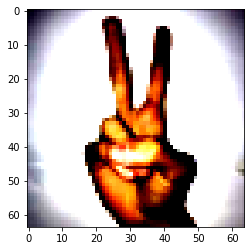

In [ ]:
show_example(*train_dt[0])

In [ ]:
print(len(val_dt),len(train_dt))

206 1806


In [ ]:
batch_sz=50
train_dl = DataLoader(train_dt, batch_sz, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dt, batch_sz*2, num_workers=4, pin_memory=True)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


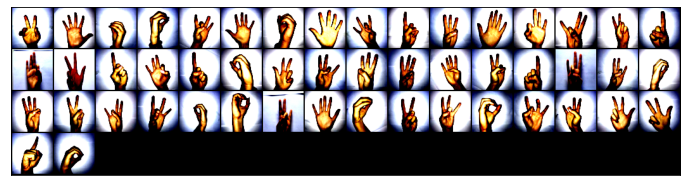

In [ ]:
show_batch(train_dl)

In [ ]:
# Save current project progress
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/boyoforex/zero2gans-course-project


'https://jovian.ai/boyoforex/zero2gans-course-project'

# Model to use

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

We will use the ResNet9 to add resudial block. The goal of this is to adds the original input back into the output feature map.

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class GenderResnet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64, pool=True)    # 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 16 x 16
        
        self.conv3 = conv_block(128, 256, pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True) # 512 X 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 4 x 4
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = GenderResnet9(3,10)
model

GenderResnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, 

Let's verify that the model produces the expected output on a batch of training data.

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([50, 3, 64, 64])
out.shape: torch.Size([50, 10])
out[0]: tensor([-0.3937, -0.2611, -2.3763, -1.9826, -3.0827, -2.1971, -4.5975,  0.8633,
         3.0329,  1.4464], grad_fn=<SelectBackward>)


To check if a GPU is availale to speed up the computation

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
# Save current project progress
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/boyoforex/zero2gans-course-project


'https://jovian.ai/boyoforex/zero2gans-course-project'

# Training the model
The first step here is to make possible improvements to the fit function

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

    
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.09333333373069763, 'val_loss': 2.321312427520752}]

The model training uses the Adam optimizer (https://ruder.io/optimizing-gradient-descent/index.html) based on momentum and adaptive learning rates. This can help speed up the training compared to typical stochastic gradient descent.

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history = []
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 1.5224, val_loss: 1.7759, val_acc: 0.6433
Epoch [1], train_loss: 0.7133, val_loss: 1.3482, val_acc: 0.7644
Epoch [2], train_loss: 0.9196, val_loss: 6.2454, val_acc: 0.3778
Epoch [3], train_loss: 0.7719, val_loss: 2.2967, val_acc: 0.6244
Epoch [4], train_loss: 0.4723, val_loss: 0.2111, val_acc: 0.8778
Epoch [5], train_loss: 0.1449, val_loss: 0.0828, val_acc: 0.9800
Epoch [6], train_loss: 0.0761, val_loss: 0.0844, val_acc: 0.9833
Epoch [7], train_loss: 0.0688, val_loss: 0.0381, val_acc: 0.9900
Epoch [8], train_loss: 0.0269, val_loss: 0.0053, val_acc: 1.0000
Epoch [9], train_loss: 0.0423, val_loss: 0.0093, val_acc: 0.9933
CPU times: user 18min 31s, sys: 15.5 s, total: 18min 47s
Wall time: 19min 5s


# Visualization
The model achieved an unbelievable accuracy close to perfection under 20 minutes of training! Anyway, let's see how the model improves over time by plotting a graph of:

(a) Accuracy vs Number of Epoch
(b) Loss vs Number of Epoch
(c) Learning Rate vs Batch Number



In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

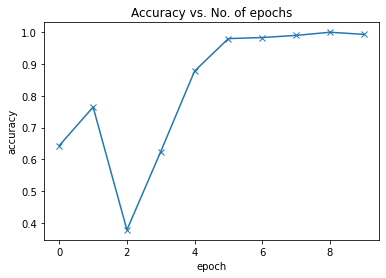

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

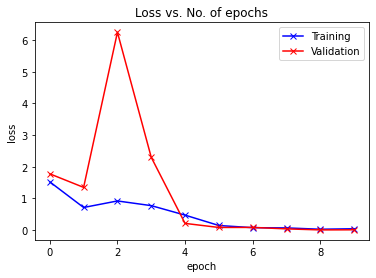

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

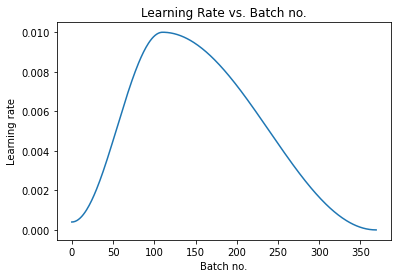

In [ ]:
plot_lrs(history)

In [ ]:
# Save current project progress
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/boyoforex/zero2gans-course-project


'https://jovian.ai/boyoforex/zero2gans-course-project'

# Model Testing
Here, we will test our trained model with some images from the test dataset.

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return data.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 7 , Predicted: 7


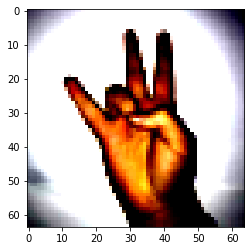

In [ ]:
img, label = test_dt[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', label, ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 2 , Predicted: 2


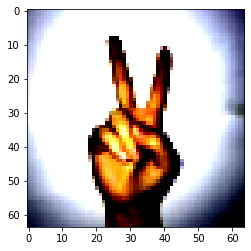

In [ ]:
img, label = test_dt[20]
plt.imshow(img.permute(1, 2, 0))
print('Label:', label, ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 1 , Predicted: 1


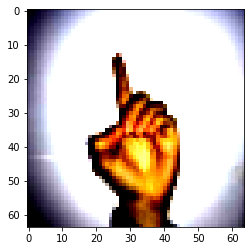

In [ ]:
img, label = test_dt[45]
plt.imshow(img.permute(1, 2, 0))
print('Label:', label, ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 9 , Predicted: 9


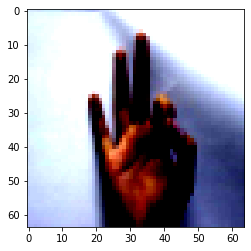

In [ ]:
img, label = test_dt[12]
plt.imshow(img.permute(1, 2, 0))
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dt, batch_sz*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 1.0, 'val_loss': 0.0020661046728491783}

In [ ]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

[jovian] Metrics logged.


In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/boyoforex/zero2gans-course-project


'https://jovian.ai/boyoforex/zero2gans-course-project'

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


# Saving the model
It is better to save the weights of the model to disk, so that we can reuse the model later and avoid retraining from scratch



In [ ]:
torch.save(model.state_dict(), 'handprint-resnet.pth')

In [ ]:
model1 = to_device(GenderResnet9(3,10), device)

In [ ]:
jovian.commit(project=project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/boyoforex/zero2gans-course-project


'https://jovian.ai/boyoforex/zero2gans-course-project'